<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 - Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

In the previous two notebooks (**transfer learning part 1: feature extraction** and **part 2: fine-tuning**) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from  using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original Food101 paper's results with 10% of data**.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
***Machine learning practitioners are serial experimenters. Start small, get a model working, see if yout experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

## What we're going to cover

We're going to go through the follow with TensorFlow:
- Downloading and preparing 10% of the Food101 data (10% of training data).
- Training a feature extraction transfer learning model on 10% of the Food101 training data.
- Fine-tuning our feature extraction model.
- Saving and loaded our trained model.
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food.

In [1]:
# Are we using a GPU?
!nvidia-smi

Tue Nov  1 16:01:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper Functions


We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from the Github repo.


In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py

--2022-11-01 16:01:50--  https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4405 (4.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   4.30K  --.-KB/s    in 0s      

2022-11-01 16:01:50 (53.0 MB/s) - ‘helper_functions.py’ saved [4405/4405]



In [3]:
# Import series of helper function for the notebook
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir, create_tensorboard_callback

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original Food101 dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 images.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

## Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [ Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We download the data as a zip file so we'll use our unzip_data() function to unzip it.

In [4]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-11-01 16:01:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  91.9MB/s    in 17s     

2022-11-01 16:02:10 (89.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [6]:
# train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# Walk through our dir
walk_through_dir("101_food_classes_10_percent")

101_food_classes_10_percent: There are 2 directories and 0 files
101_food_classes_10_percent/train: There are 101 directories and 0 files
101_food_classes_10_percent/train/spaghetti_bolognese: There are 0 directories and 75 files
101_food_classes_10_percent/train/tuna_tartare: There are 0 directories and 75 files
101_food_classes_10_percent/train/ice_cream: There are 0 directories and 75 files
101_food_classes_10_percent/train/risotto: There are 0 directories and 75 files
101_food_classes_10_percent/train/onion_rings: There are 0 directories and 75 files
101_food_classes_10_percent/train/red_velvet_cake: There are 0 directories and 75 files
101_food_classes_10_percent/train/panna_cotta: There are 0 directories and 75 files
101_food_classes_10_percent/train/pizza: There are 0 directories and 75 files
101_food_classes_10_percent/train/prime_rib: There are 0 directories and 75 files
101_food_classes_10_percent/train/french_fries: There are 0 directories and 75 files
101_food_classes_10_pe

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beeat the baseline from original **Food101 paper** (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

- A `ModelCheckpoint` callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time.
- Data augmentation built right into the model
- A headless (no top layers) `EfficientNetB0` architecture from `
tf.keras.applications` as our base model.
- A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer.
- Categorical crossentropy as the loss function since we're dealing with more than two classes.
- The Adam optimizer with the default settings.
- Fitting for 5 full passes on the training data while evaluating on 15% of the test data.

It seems like a lot but these are all things we've covered before in the **Transfer Learning in TensorFlow Part 2: Fine-tuning notebook**.

Let's start by creating the `ModelCheckpoint` callback.

In [ ]:
# Create a ModelCheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 and 1 (not need for EfficientNet models)
], name="data_augmentation_layer")

We'll able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using `tf.keras.applications.EfficientNetB0` as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` followed by a `Dense` layer.

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # pool the outputs of the base model
model = tf.keras.Model(inputs, outputs)

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png)

In [ ]:
# summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model frozen whilst allowing the model to tune its outputs to our custom data.

In [ ]:
# compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")

# fit the model
history_featExtraction_model = model.fit(train_data,
                                         epochs=5,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="feature_extraction_model"), checkpoint_callback])

Saving TensorBoard log files to :transfer_learning/feature_extraction_model/2022-10-18_17:57:28
Epoch 1/5
237/237 [==============================] - 101s 356ms/step - loss: 3.3891 - accuracy: 0.2701 - val_loss: 2.4793 - val_accuracy: 0.4592
Epoch 2/5
237/237 [==============================] - 69s 286ms/step - loss: 2.2255 - accuracy: 0.4919 - val_loss: 2.0155 - val_accuracy: 0.5212
Epoch 3/5
237/237 [==============================] - 64s 268ms/step - loss: 1.8604 - accuracy: 0.5585 - val_loss: 1.8543 - val_accuracy: 0.5392
Epoch 4/5
237/237 [==============================] - 64s 268ms/step - loss: 1.6440 - accuracy: 0.5999 - val_loss: 1.7745 - val_accuracy: 0.5421
Epoch 5/5
237/237 [==============================] - 61s 255ms/step - loss: 1.4817 - accuracy: 0.6407 - val_loss: 1.7624 - val_accuracy: 0.5418


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 66s 83ms/step - loss: 1.5890 - accuracy: 0.5830


Well it looks like we just beat our baseline (the results from the original Food101 paper) with 10% of the data! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

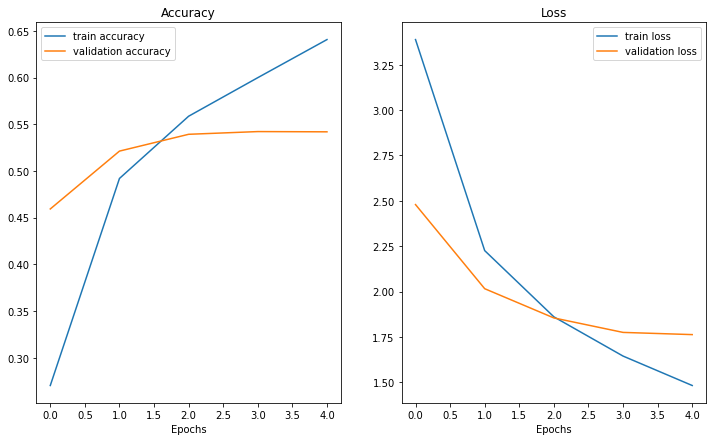

In [ ]:
# loss curves
plot_loss_curves(history_featExtraction_model)

## Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen. 

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model so we need to recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)

In [ ]:
# Recompile the model with lower learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Check which layers are trainable in our base model?
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

Another 5 epochs should be enough to see whether any benefits come about.

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [ ]:
# fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_fine_tune_5_layers_model = model.fit(train_data,
                                             epochs = fine_tune_epochs,
                                             steps_per_epoch=len(train_data),
                                             validation_data=test_data,
                                             validation_steps=int(0.15 * len(test_data)),
                                             initial_epoch=history_featExtraction_model.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 66s 240ms/step - loss: 1.2342 - accuracy: 0.6809 - val_loss: 1.6909 - val_accuracy: 0.5530
Epoch 6/10
237/237 [==============================] - 54s 225ms/step - loss: 1.1447 - accuracy: 0.6964 - val_loss: 1.6910 - val_accuracy: 0.5522
Epoch 7/10
237/237 [==============================] - 52s 217ms/step - loss: 1.0713 - accuracy: 0.7064 - val_loss: 1.6801 - val_accuracy: 0.5538
Epoch 8/10
237/237 [==============================] - 52s 217ms/step - loss: 0.9812 - accuracy: 0.7333 - val_loss: 1.7211 - val_accuracy: 0.5469
Epoch 9/10
237/237 [==============================] - 52s 219ms/step - loss: 0.9270 - accuracy: 0.7545 - val_loss: 1.6631 - val_accuracy: 0.5572
Epoch 10/10
237/237 [==============================] - 51s 211ms/step - loss: 0.8799 - accuracy: 0.7661 - val_loss: 1.6752 - val_accuracy: 0.5508


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [ ]:
fine_tune_5_layers_model_results = model.evaluate(test_data)
fine_tune_5_layers_model_results

790/790 [==============================] - 76s 96ms/step - loss: 1.4783 - accuracy: 0.6064


[1.4782756567001343, 0.606415867805481]

It seems like our model got a slight boost from fine-tuning

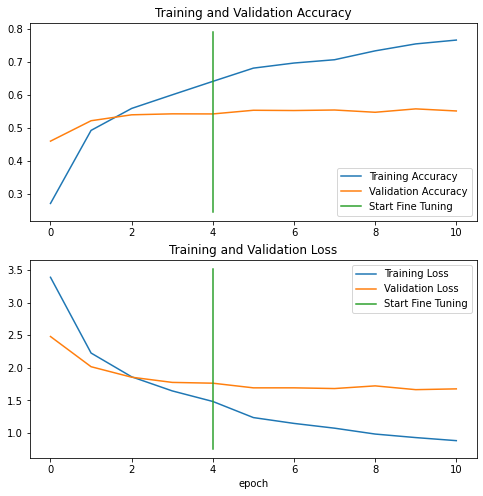

In [ ]:
# Compare the historys 
compare_historys(original_history=history_featExtraction_model,
                 new_history=history_fine_tune_5_layers_model,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation not so much. Looks like our model is starting to overfit.

This is ok though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on **ImageNet** which contains many real life pictures of food just like our food dataset.

If feature extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Saving our trained model

To prevent having to retrain our model from scratch let's save it to file using the `save()` methode.

In [ ]:
# Save our fine-tuning model
# model.save("/content/drive/MyDrive/Colab Notebooks/Zero_To_Mastery/101_food_classes_10_percent_saved_big_dog_model")

In [9]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Zero_To_Mastery/101_food_classes_10_percent_saved_big_dog_model")

To make sure our loaded model is indead a trained model, let's evaluate its performance on the test dataset.

In [10]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 78s 87ms/step - loss: 1.4977 - accuracy: 0.6021


[1.497715950012207, 0.6020594239234924]

In [11]:
# Check if the results are the same than our model results
fine_tune_5_layers_model_results

NameError: ignored

## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [12]:
import tensorflow as tf

# Download a pre-trained model from google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-11-01 16:06:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   180MB/s    in 0.2s    

2022-11-01 16:06:20 (180 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [13]:
# unzip the data
saved_model_path = "/content/06_101_food_class_10_percent_saved_big_dog_model.zip"

unzip_data(saved_model_path)

In [14]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [15]:
# check to see if loaded model is a trained model
loaded_model_loss, loaded_model_acc = model.evaluate(test_data)
loaded_model_loss, loaded_model_acc

790/790 [==============================] - 66s 81ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

## Making predictions with our trained model

To evaluated our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class of how likely the image is to be that class.

In [16]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 65s 81ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in each.

So if we had 25250 images in the test dataset, how many predictions do we have ?

In [17]:
# How many predictions?
len(preds_probs)

25250

In [18]:
# Shape of the predictions
preds_probs.shape

(25250, 101)

We have 25250 predictions corresponding to the 25250 images in the test dataset. Each prediction is a tensor with 101 results corresponding to the 101 classes.

In [19]:
# Let's plot the first prediction
preds_probs[0]

array([5.9542041e-02, 3.5742053e-06, 4.1376803e-02, 1.0660536e-09,
       8.1613978e-09, 8.6639664e-09, 8.0927055e-07, 8.5652584e-07,
       1.9859037e-05, 8.0977844e-07, 3.1727685e-09, 9.8673934e-07,
       2.8532150e-04, 7.8048906e-10, 7.4230199e-04, 3.8916383e-05,
       6.4740493e-06, 2.4977257e-06, 3.7891168e-05, 2.0678289e-07,
       1.5538468e-05, 8.1507341e-07, 2.6230621e-06, 2.0010727e-07,
       8.3827535e-07, 5.4215934e-06, 3.7391037e-06, 1.3150533e-08,
       2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574906e-05,
       1.6688929e-04, 7.6407003e-10, 4.0452901e-04, 1.3150634e-08,
       1.7957395e-06, 1.4448203e-06, 2.3062935e-02, 8.2466863e-07,
       8.5365861e-07, 1.7138630e-06, 7.0525307e-06, 1.8402273e-08,
       2.8553430e-07, 7.9483771e-06, 2.0681496e-06, 1.8525223e-07,
       3.3619774e-08, 3.1522568e-04, 1.0410943e-05, 8.5448448e-07,
       8.4741873e-01, 1.0555466e-05, 4.4094878e-07, 3.7404185e-05,
       3.5306264e-05, 3.2489010e-05, 6.7314875e-05, 1.2852592e

In [20]:
# Let's plot the 10 first predictions
preds_probs[:10]

array([[5.9542041e-02, 3.5742053e-06, 4.1376803e-02, ..., 1.4138708e-09,
        8.3530598e-05, 3.0897530e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8361918e-12, 9.8465647e-10],
       [9.5925879e-01, 3.2533717e-05, 1.4866921e-03, ..., 7.1891350e-07,
        5.4397532e-07, 4.0276082e-05],
       ...,
       [4.7313261e-01, 1.2931234e-07, 1.4805571e-03, ..., 5.9750129e-04,
        6.6969093e-05, 2.3469318e-05],
       [4.4571854e-02, 4.7265522e-07, 1.2258522e-01, ..., 6.3498674e-06,
        7.5318649e-06, 3.6778811e-03],
       [7.2438961e-01, 1.9249846e-09, 5.2310996e-05, ..., 1.2291390e-03,
        1.5792685e-09, 9.6395743e-05]], dtype=float32)

In [21]:
# We got one prediction probability per class
print(f"Number of predictions probabilities for sample 0: {len(preds_probs[0])}")
print(f"The class with highest predicted probability by the model for sample 0: {tf.argmax(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: {preds_probs[0]}")

Number of predictions probabilities for sample 0: 101
The class with highest predicted probability by the model for sample 0: 52
What prediction probability sample 0 looks like: [5.9542041e-02 3.5742053e-06 4.1376803e-02 1.0660536e-09 8.1613978e-09
 8.6639664e-09 8.0927055e-07 8.5652584e-07 1.9859037e-05 8.0977844e-07
 3.1727685e-09 9.8673934e-07 2.8532150e-04 7.8048906e-10 7.4230199e-04
 3.8916383e-05 6.4740493e-06 2.4977257e-06 3.7891168e-05 2.0678289e-07
 1.5538468e-05 8.1507341e-07 2.6230621e-06 2.0010727e-07 8.3827535e-07
 5.4215934e-06 3.7391037e-06 1.3150533e-08 2.7761499e-03 2.8051867e-05
 6.8562162e-10 2.5574906e-05 1.6688929e-04 7.6407003e-10 4.0452901e-04
 1.3150634e-08 1.7957395e-06 1.4448203e-06 2.3062935e-02 8.2466863e-07
 8.5365861e-07 1.7138630e-06 7.0525307e-06 1.8402273e-08 2.8553430e-07
 7.9483771e-06 2.0681496e-06 1.8525223e-07 3.3619774e-08 3.1522568e-04
 1.0410943e-05 8.5448448e-07 8.4741873e-01 1.0555466e-05 4.4094878e-07
 3.7404185e-05 3.5306264e-05 3.2489010e-0

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probability value, the less the model thinks that the target image is that specific class.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [22]:
# Get the pred classes of each label
pred_classes = tf.argmax(preds_probs,axis=1)
pred_classes

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([ 52,   0,   0, ..., 100,  94, 100])>

In [23]:
# First 10 classes
pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])>

We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the `unbatc()` method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the **argmax()** method to return the index of the label.

> **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [24]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since test_data isn't shuffled, the y_labels array comes back in the same order as the pred_classes array.

In [25]:
# How many y_labels are there?

len(y_labels)

25250

As expected, the number of labels matches the number of images we've got. Time to compare our model's predictions with the ground truth labels.

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

A very simple evaluation is to use Scikit-Learn's `accuracy_score()` function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value as the `evaluate()` method we used earlier.

In [26]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [27]:
# accuracy result of the loaded model with the evaluate method
loaded_model_acc

0.6077623963356018

In [28]:
# Does this metric come close to our model's evaluate results?
import numpy as np
isclose = np.isclose(sklearn_accuracy,loaded_model_acc)
diff = abs(sklearn_accuracy-loaded_model_acc)

print(f"Is close:{isclose} | Difference: {diff}")

Is close:True | Difference: 2.0097978059574473e-08


It looks like our **pred_classes** array and **y_labels** array are in the right orders.

Let's plot a confusion matrix using `make_confusion_matrix` function we created in a previous notebook or we will create a new one.

In [29]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

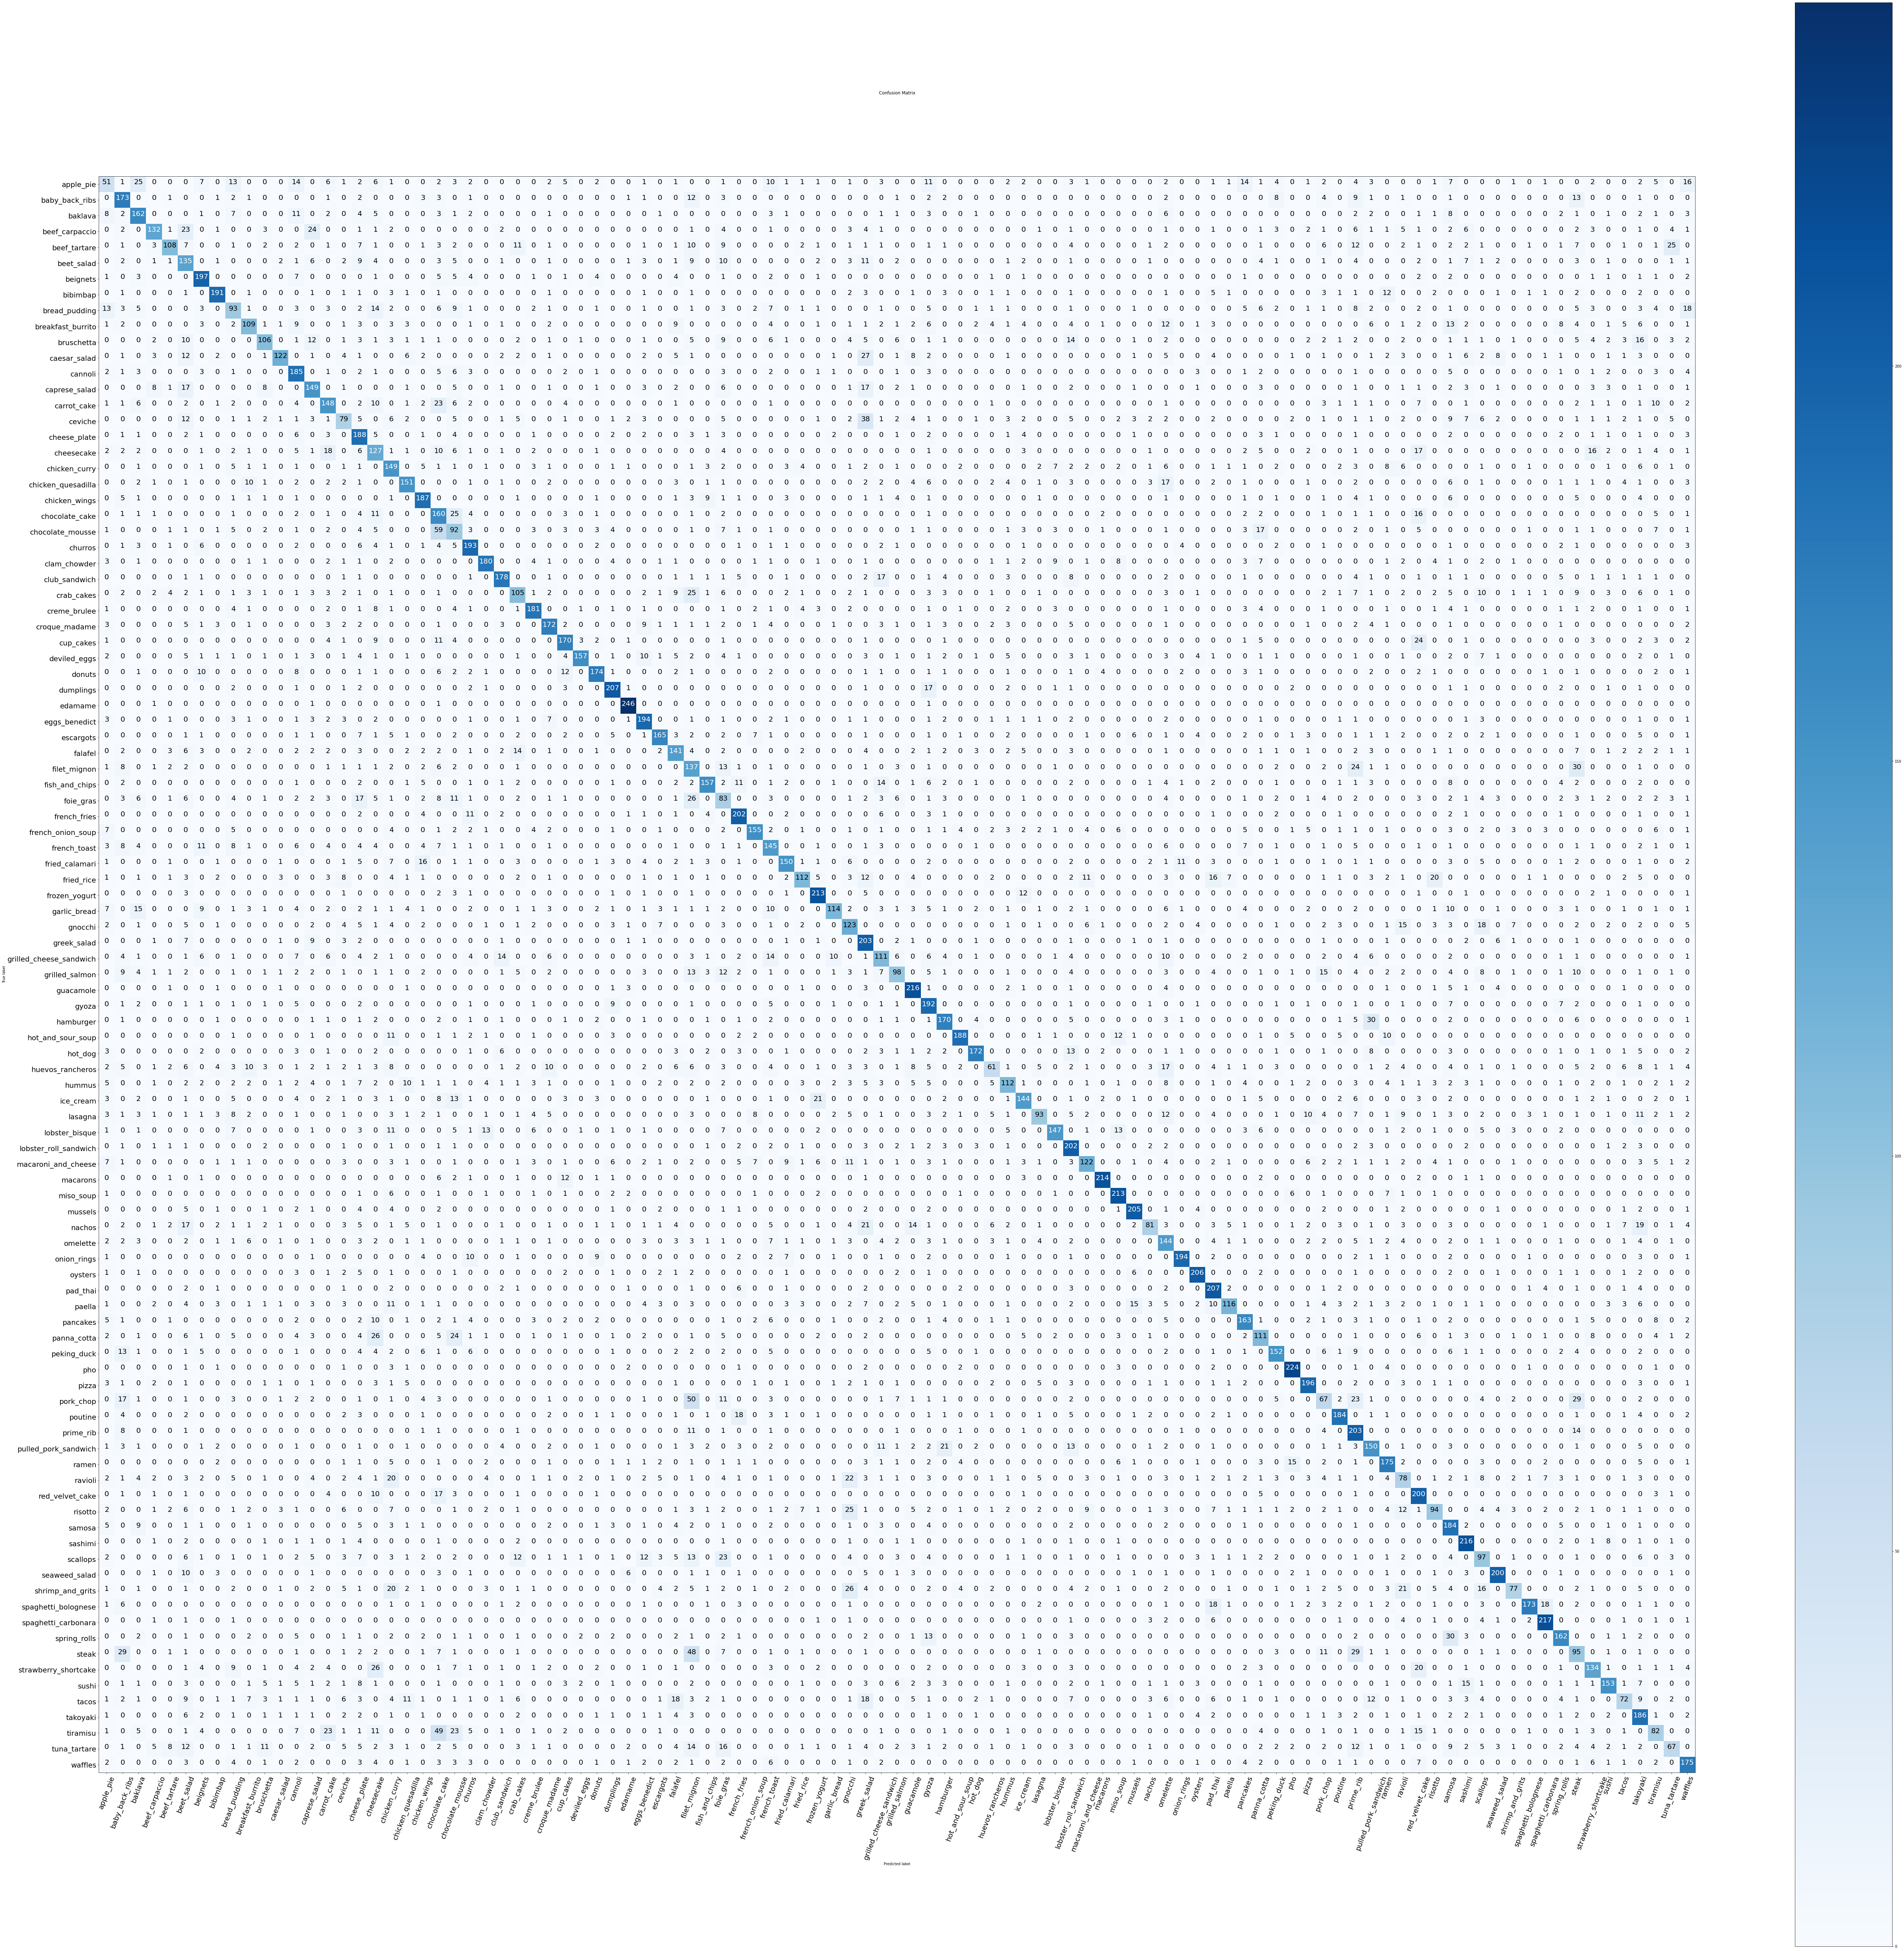

In [ ]:
# plot a confusion matrix with all predictions
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=False)

We get a big confusion matrix. It may look a little daunting at first but after zooming in a little we can see how it gives us insight into which classes its getting "confused" on.

The good new is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting *filet_mignon* for instances of *pork_chop* and *chocolate_cake* for instances of *tiramisu*.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()` function.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
- **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
- **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
- **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [32]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [33]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [34]:
# Create an empty dictionary
class_f1_scores = {}

# Loop through classification report item
for key, val in classification_report_dict.items():

  if key == "accuracy": # stop once we get to accuracy key
    break
  else:
    # append class names and f1-scores to new dictionary
    key_class = class_names[int(key)]
    class_f1_scores[key_class] = val['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [35]:
# Turn f1-score into dataframe for visualization
import pandas as pd

df_f1_scores = pd.DataFrame({"class_names":class_f1_scores.keys(),
                             "f1_score": class_f1_scores.values()}).sort_values("f1_score", ascending=False)

df_f1_scores

,class_names,f1_score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


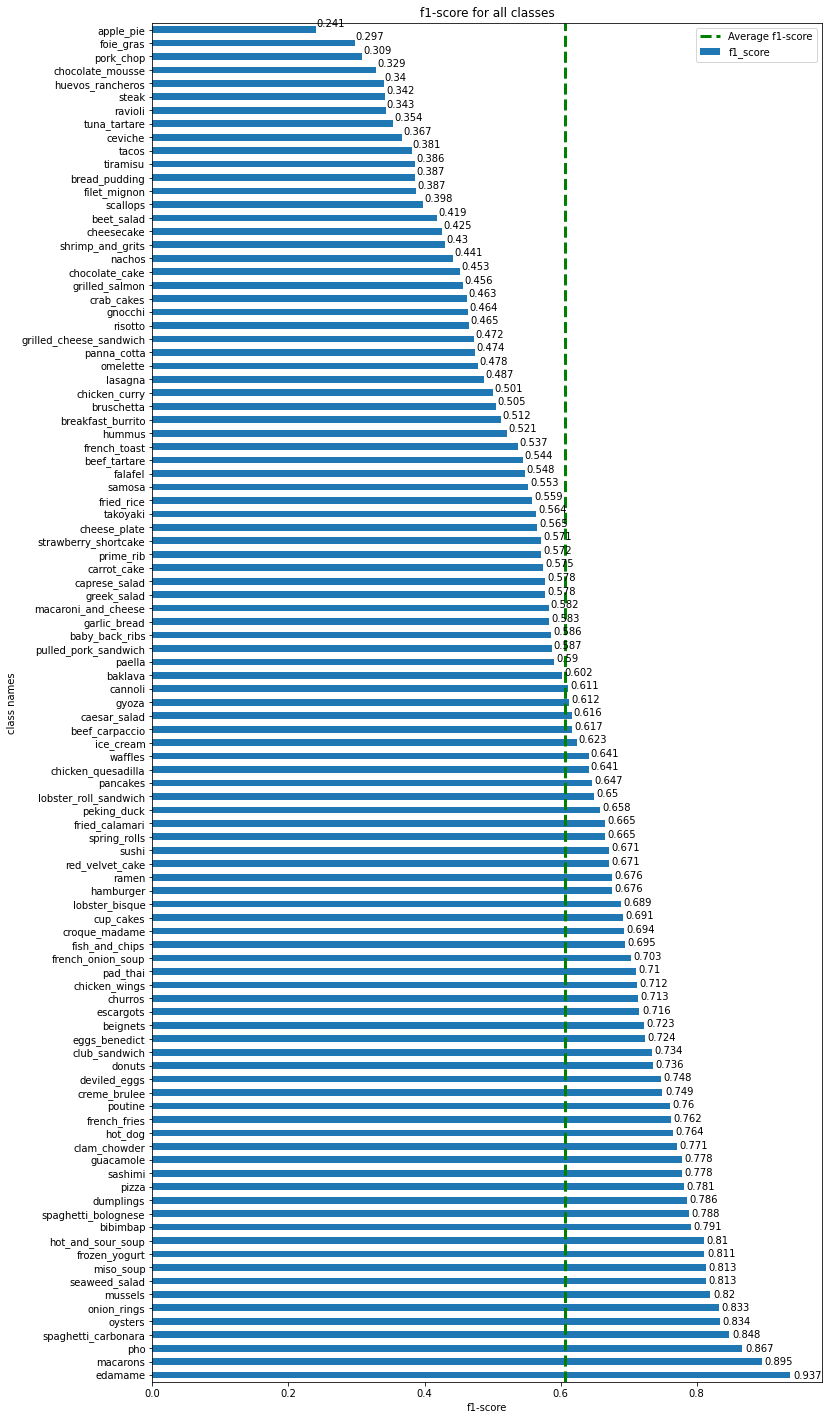

In [36]:
# visualize the results in a figure
import matplotlib.pyplot as plt

# create a bar plot
fig, ax = plt.subplots(figsize=(12,25))
df_f1_scores.plot(kind="barh", ax=ax)
ax.axvline(df_f1_scores["f1_score"].mean(),color="green", lw=3, ls='--', label="Average f1-score")
ax.set_yticklabels(list(df_f1_scores["class_names"]))
ax.set_ylabel("class names")
ax.set_xlabel("f1-score")
ax.set_title("f1-score for all classes")

# add annotation text
for p in ax.patches:
  ax.annotate(str(round(p.get_width(),3)), (p.get_width() * 1.005, p.get_y() * 1.005))

plt.legend() 
plt.show()

It seems like our model performs fairly poorly on classes like `apple_pie` and `ravioli` while for classes like `edaname` and `pho` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

## Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrcics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any omage of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
- Read in a target image filepath using `tf.io.read_file()`
- Turn the image into a `Tensor` using `tf.io.decode_image()`
- Resize the image to be the same size as the images our model has been trained on (224 x 224) using `tf.image.resize()`.
- Scale the image to get all the pixel values between 0 and 1 if necessary.

In [37]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape=(224,224), scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapahes
  into a specified shape (img_shape[0], img_shape[1], color_channels=3)

  Arguments:
  - filename(str): path to target image
  - img_shape (tuple): resize the input image into a size (height, width)
  - scale (bool): whether to scale pixel values to range(0,1), default True
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape[0], img_shape[1]])

  if scale:
    # Rescale the image (get all values between 0 and 1)
    img = img / 255.
    
  return img


Image loading and preprocessing function is ready.

Now let's write some code to:
1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 [==============================] - 0s 26ms/step


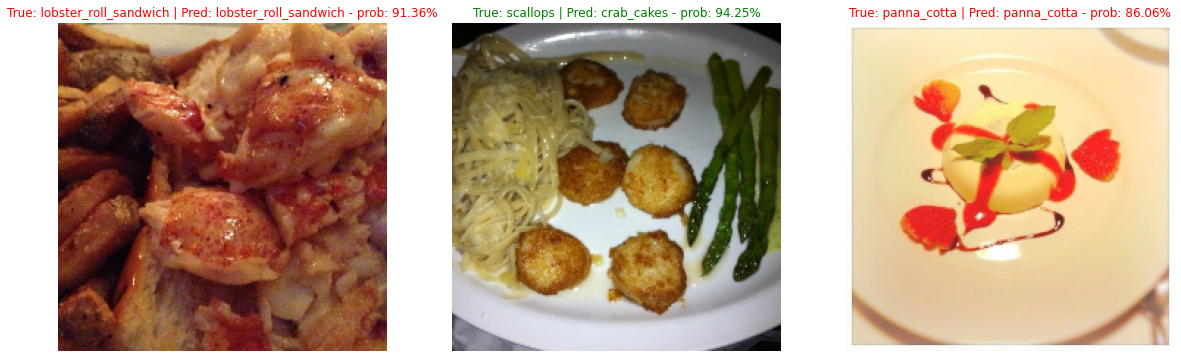

In [38]:
# Make preds on a series of random images
import random
import os

plt.figure(figsize=(20,10))

for i in range(3):

  # Choose a random image(s) from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make prediction
  img = load_and_prep_image(filepath, scale=False)
  img_expand_dims = tf.expand_dims(img, axis=0) # expand dims before put the image into the model
  pred_probs = model.predict(img_expand_dims)

  pred_prob = pred_probs.max()
  pred_class = class_names[pred_probs.argmax()]
  
  # plot the image
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  plt.axis('off')

  if pred_class == class_name:
    title_color = "red"
  else:
    title_color = "green"

  title = f"True: {class_name} | Pred: {pred_class} - prob:{pred_prob: .2%}"
  plt.title(title, color=title_color)
plt.show()

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as `baby_back_ribs` getting mistaken as `steak` and vice versa.

## Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediciton wrong.

We'll go through the following steps.
1. Get all of the image file paths in the test dataset using the `list_files()` method.
2. Create a pandas dataframe of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  - Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [41]:
# 1. Get all of the images file paths in the test dataset
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

- Their ground truth labels (`y_labels`).
- The class the model predicted (`pred_classes`).
- The maximum prediction probability value (`pred_probs.max(axis=1)`).
- The ground truth class names.
- The predicted class names.


In [53]:
# 2. Create a DataFrame of different paths
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})


pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658606,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib


In [54]:
# 3. is the prediction correct ?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658606,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib,False


In [57]:
# 4. Get the top 100 wrong predictions
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
8763,b'/content/101_food_classes_10_percent/test/es...,35,41,0.997169,escargots,french_onion_soup,False
2663,b'/content/101_food_classes_10_percent/test/br...,10,61,0.997055,bruschetta,lobster_roll_sandwich,False
7924,b'/content/101_food_classes_10_percent/test/do...,31,29,0.997020,donuts,cup_cakes,False
18586,b'/content/101_food_classes_10_percent/test/pe...,74,39,0.996885,peking_duck,foie_gras,False


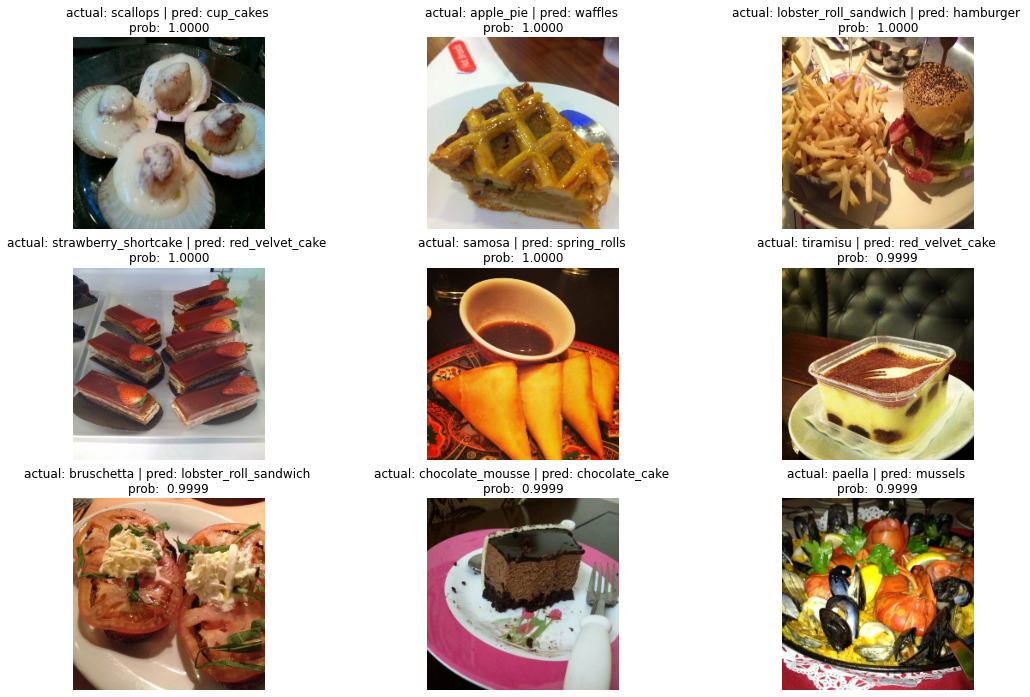

In [90]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 0

plt.figure(figsize=(18,12))
for i, row in enumerate(top_100_wrong[start_index: start_index+images_to_view].itertuples()):

  # get data from the row
  _, img_path, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(img_path, scale=False)
  plt.imshow(img/255)
  plt.axis(False)
  plt.title(f"actual: {y_true_classname} | pred: {y_pred_classname} \nprob: {pred_prob : .4f}")
plt.show()

Going through the model's most wrong predictions can usually help figure out a couple of things:
- **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use ou model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as **[active learning](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/)**.
- **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the big dog model on test images as well as custom images of food.

